In [6]:
import os
import gc
import time
import math
import numpy as np
import pandas as pd
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from glob import glob
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader


# Helpers

In [7]:
def accuracy(y_pred, y_true):
    return torch.sum((y_true * y_pred) > 0.5) / torch.sum(y_true)

def stem(file):
    return file.split("/")[-1]

def find_files(directory, pattern='**/*.wav'):
    """Recursively finds all files matching the pattern."""
    return glob(os.path.join(directory, pattern), recursive=True)

def seed_everywhere():
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

class AverageMeter:
    def __init__(self, name:str, momentum=0.95):
        assert 0.0 <= momentum < 1.0
        
        self.name = name
        self.momentum = momentum
        self.x = None
        
    def __str__(self):
        return str("{} -> {:0.3f}".format(self.name, self.x))
    
    def get(self):
        return self.x
        
    def reset(self):
        self.x = None
        
    def step(self, x: float):
        if self.x is None:
            self.x = x
        else:
            self.x = self.momentum * self.x + (1 - self.momentum) * x
            
class Timer(object):
    def __init__(self):
        self._tic = time.time()

    def tic(self):
        self._tic = time.time()
        return self._tic

    def toc(self):
        return time.time() - self._tic

    def tictoc(self):
        _toc = time.time()
        duration = _toc - self._tic
        self._tic = _toc
        return duration

In [8]:
class Sound:
    def __init__(self, 
                 path, 
                 sound_id=None,
                 meta=None, 
                 samplerate=None):
        self.path = str(path)
        self.sound_id = sound_id
        self.samplerate = samplerate
        self.meta = meta

In [18]:
>>> # target output size of 5
>>> m = nn.AdaptiveAvgPool1d(1)
>>> input_ = torch.tensor([[[1., 2., 3.]],
                          [[4., 5., 6.]]])
>>> output = m(input)
print(output.shape)

torch.Size([2, 1, 1])


In [19]:
output

tensor([[[2.]],

        [[5.]]])

In [20]:
class SEModule(nn.Module):
    def __init__(self, channels, bottleneck=128):
        super(SEModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm1d(bottleneck),
            nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
            nn.Sigmoid(),
            )

    def forward(self, input):
        x = self.se(input)
        return input * x
    
sem = SEModule(1)
sem(input_)

tensor([[[0.4419, 0.8838, 1.3258]],

        [[2.2799, 2.8499, 3.4198]]], grad_fn=<MulBackward0>)

# Neural Model and Loss
link: https://arxiv.org/abs/2005.07143

In [4]:
class SEModule(nn.Module):
    def __init__(self, channels, bottleneck=128):
        super(SEModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm1d(bottleneck),
            nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
            nn.Sigmoid(),
            )

    def forward(self, input):
        x = self.se(input)
        return input * x

class Bottle2neck(nn.Module):

    def __init__(self, inplanes, planes, kernel_size=None, dilation=None, scale = 4):

        super(Bottle2neck, self).__init__()

        width       = int(math.floor(planes / scale))
        
        self.conv1  = nn.Conv1d(inplanes, width*scale, kernel_size=1)
        self.bn1    = nn.BatchNorm1d(width*scale)
        
        self.nums   = scale -1

        convs       = []
        bns         = []

        num_pad = math.floor(kernel_size/2)*dilation

        for i in range(self.nums):
            convs.append(nn.Conv1d(width, width, kernel_size=kernel_size, dilation=dilation, padding=num_pad))
            bns.append(nn.BatchNorm1d(width))

        self.convs  = nn.ModuleList(convs)
        self.bns    = nn.ModuleList(bns)

        self.conv3  = nn.Conv1d(width*scale, planes, kernel_size=1)
        self.bn3    = nn.BatchNorm1d(planes)

        self.relu   = nn.ReLU()

        self.width  = width
        self.se     = SEModule(planes)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn1(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i==0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(sp)
            sp = self.bns[i](sp)
            if i==0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
                
        out = torch.cat((out, spx[self.nums]),1)
        out = self.conv3(out)
        out = self.relu(out)
        out = self.bn3(out)
        out = self.se(out)
        out += residual

        return out 

class ECAPA(nn.Module):
    def __init__(self, 
                 C, 
                 model_scale, 
                 dim_out,
                 features_dim, 
                 encoder_type="ASP",
                 context=False, 
                 summed=False, 
                 out_bn=False):

        super().__init__()

        self.context = context
        self.summed = summed
        self.features_dim = features_dim
        self.encoder_type = encoder_type
        self.out_bn = out_bn

        self.scale  = model_scale

        self.conv1  = nn.Conv1d(self.features_dim, C, kernel_size=5, stride=1, padding=2)
        self.relu   = nn.ReLU()
        self.bn1    = nn.BatchNorm1d(C)
        
        self.layer1 = Bottle2neck(C, C, kernel_size=3, dilation=2, scale=self.scale)
        self.layer2 = Bottle2neck(C, C, kernel_size=3, dilation=3, scale=self.scale)
        self.layer3 = Bottle2neck(C, C, kernel_size=3, dilation=4, scale=self.scale)
        self.layer4 = nn.Conv1d(3*C, 1536, kernel_size=1)

        if self.context:
            attn_input = 1536*3
        else:
            attn_input = 1536

        if self.encoder_type == 'ECA':
            attn_output = 1536
        elif self.encoder_type == 'ASP':
            attn_output = 1
        else:
            raise ValueError('Undefined encoder')


        self.attention = nn.Sequential(
            nn.Conv1d(attn_input, 128, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, attn_output, kernel_size=1),
            nn.Softmax(dim=2),
            )

        self.bn5 = nn.BatchNorm1d(3072)

        self.fc6 = nn.Linear(3072, dim_out)
        if self.out_bn:
            self.bn6 = nn.BatchNorm1d(dim_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)

        if self.summed:
            x1 = self.layer1(x)
            x2 = self.layer2(x+x1)
            x3 = self.layer3(x+x1+x2)
        else:
            x1 = self.layer1(x)
            x2 = self.layer2(x1)
            x3 = self.layer3(x2)

        x = self.layer4(torch.cat((x1,x2,x3),dim=1))
        x = self.relu(x)

        t = x.size()[-1]

        if self.context:
            global_x = torch.cat((x,torch.mean(x,dim=2,keepdim=True).repeat(1,1,t), torch.sqrt(torch.var(x,dim=2,keepdim=True).clamp(min=1e-4)).repeat(1,1,t)), dim=1)
        else:
            global_x = x

        w = self.attention(global_x)
        mu = torch.sum(x * w, dim=2)
        sg = torch.sqrt( ( torch.sum((x**2) * w, dim=2) - mu**2 ).clamp(min=1e-4) )
        x = torch.cat((mu, sg), 1)

        x = self.bn5(x)
        x = self.fc6(x)

        if self.out_bn:
            x = self.bn6(x)

        return x


def ECAPA_1KCSBN(model_scale=8, C=128, **kwargs):
    model = ECAPA(C=C, 
                  model_scale = model_scale, 
                  context=True, 
                  summed=True, 
                  out_bn=True, 
                  **kwargs)
    return model

class BCE(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(1, dim), requires_grad=True)
        self.bce = nn.BCEWithLogitsLoss()
        self.sigmoid = nn.Sigmoid()
        
        nn.init.xavier_normal_(self.weight, gain=1)
        
    def logit(self, x):
        return F.linear(x, self.weight)
    
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x.astype("float32")).cuda()
        with torch.no_grad():
            logit = self.logit(x)
            
        return self.sigmoid(logit)
    
    def forward(self, x, y):
        logit = self.logit(x)
        return self.bce(logit, y)

# Audio Reader

## Define Reader

In [5]:
class AudioReader:
    def __init__(self, 
                 samplerate:int, 
                 length:int = None):
        self.samplerate = samplerate
        self.length = length
        print("initialize AudioReader with samplerate: {}".format(self.samplerate))
        
    def load_audio(self, file:str, frame_offset:int=None, num_frames:int=None):
        audio, sr = torchaudio.load(file,
                                    channels_first=True,
                                    frame_offset=frame_offset,
                                    num_frames=num_frames)
        if sr != self.samplerate:
            audio = F.resample(audio, sr,  self.samplerate)
        if audio.shape[0] > 0:
            audio = torch.mean(audio, dim=0, keepdims=True)
        return audio

    def __call__(self, file, length=None):
        if length is None:
            length = self.length
        elif length == -1:
            length = None
        else:
            pass

        if length is None:
            audio = self.load_audio(file)
            return audio
        
        info = torchaudio.info(file)
        audio_length = info.num_frames

        frame_offset_max = max(audio_length - length, 0)
        if frame_offset_max > 0:
            frame_offset = random.randint(0, frame_offset_max)
        else:
            frame_offset = 0

        num_frames = min(audio_length, length)
        audio = self.load_audio(file,
                                frame_offset=frame_offset,
                                num_frames=num_frames)

        return audio

## Define Padder
It's useful for training to augment audio wave witch too short

In [6]:
class AudioPadder:
    def __init__(self, mode, value=0.0, random=False, length=None):
        """
        :param mode: mode of padding, pass to torch.pad.
        :param value: value, works only for constant_padding mode
        :param random: if true - left and right offset will be random, otherwise only right side pad
        :param length: length of final audio in samples
        """
        assert mode in ['constant', 'circular']
        self.mode = mode
        self.value = value
        self.random = random
        self.length = length

    def circular_pad(self, x: torch.Tensor, pad: tuple):
        is_squeeze = False
        if len(x.shape) == 2:
            x = x[None, ...]
            is_squeeze = True
        elif len(x.shape) == 3:
            pass
        else:
            raise "only 2D and 3D tensors supported"

        x_len = x.shape[-1]
        pad_len_left = pad[0]
        pad_len_right = pad[1]

        n_repeat_left = pad_len_left // x_len
        n_offset_left = pad_len_left % x_len
        n_repeat_right = pad_len_right // x_len
        n_offset_right = pad_len_right % x_len
        n_repeat = n_repeat_left + n_repeat_right + 1
        if n_repeat > 1:
            x = torch.cat([x] * n_repeat, dim=-1)
        x = F.pad(x, (n_offset_left, n_offset_right), mode="circular")
        if is_squeeze:
            x = x.squeeze(0)
        return x

    def __call__(self, x, length=None):
        if length is None:
            length = self.length

        if len(x.shape) < 2:
            x = x.unsqueeze(0)

        length_x = x.shape[1]
        if length_x >= length:
            return x

        if self.random:
            pad_left = max(0, length - length_x)
            pad_left = torch.randint(0, pad_left, (1,))
        else:
            pad_left = 0
        pad_right = max(0, length - length_x - pad_left)
        if self.mode == "circular":
            x = self.circular_pad(x, pad=(pad_left, pad_right))
        else:
            x = F.pad(x, (pad_left, pad_right, 0, 0), mode=self.mode)

        return x

# Audio Extractor
Extract audio from file
use combination reader and padder to create extractor

In [7]:
class RawExtractor:
    def __init__(self,
                 length,
                 dithering: float=None,
                 samplerate: int=16000,
                 normed: bool =False
                 ):
        self.dithering = dithering
        self.length = length
        self.samplerate = samplerate
        self.normed = normed       
        self.audio_loader = AudioReader(samplerate=self.samplerate,
                                        length=length)
        
        if length is not None:
            self.audio_padder = AudioPadder(mode="constant",
                                            length=length,
                                            random=True
                                            )
        else:
            self.audio_padder = None

    def make_dithering(self, audio):
        return audio + self.dithering * torch.rand_like(audio)
    
    def normalize(self, audio):
        audio = audio - torch.mean(audio)
        audio = audio / (torch.std(audio) + 1e-6)
        return audio
        
    def __call__(self, sound):
        if not isinstance(sound, str):
            sound = sound.path
            
        audio = self.audio_loader(file=sound, length=self.length)
            
        if self.normed:
            audio = self.normalize(audio)
            
        if self.audio_padder is not None:
            audio = self.audio_padder(x=audio, length=self.length)
            
        if self.dithering is not None:
            audio = self.make_dithering(audio)
            
        return audio

# Features Extractor

## MFCC

In [8]:
class MFCC(nn.Module):
    def __init__(self,
                 win_length: int,
                 hop_length: int,
                 n_fft: int, 
                 n_mels: int, 
                 n_mfcc: int,
                 f_min: float, 
                 f_max: float, 
                 sample_rate: int,
                 log_mels=False,
                 instancenorm=False
                 ):
        super().__init__()
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.f_min = f_min
        self.f_max = f_max
        self.n_mels = n_mels
        self.n_mfcc = n_mfcc
        self.sample_rate = sample_rate
        self.window_fn = torch.hamming_window
        self.log_mels = log_mels
        
        mfcc = torchaudio.transforms.MFCC
        self.extractor = mfcc(sample_rate=self.sample_rate, 
                              n_mfcc = self.n_mfcc, 
                              log_mels=self.log_mels, 
                              dct_type = 2, 
                              melkwargs={'n_mels': self.n_mels, 
                                         'n_fft':self.n_fft, 
                                         'win_length':self.win_length, 
                                         'hop_length':self.hop_length, 
                                         'f_min':self.f_min, 
                                         'f_max':self.f_max, 
                                         'window_fn':self.window_fn})
        
        if instancenorm:
            self.instancenorm   = nn.InstanceNorm1d(self.n_mels)
        else:
            self.instancenorm = None
        
    def dim(self):
        return self.n_mfcc
    
    @torch.no_grad()
    def forward(self, x):
        with torch.cuda.amp.autocast(enabled=False):
            if x.dim() == 3:
                x = x.squeeze(1)

            f = self.extractor(x)
            if self.instancenorm is not None:
                f = self.instancenorm(f)

            return f

## FBANK

In [9]:
class Fbank(nn.Module):
    def __init__(self, 
                 win_length: int,
                 hop_length: int,
                 n_fft: int, 
                 f_min: float, 
                 f_max: float, 
                 n_mels: int, 
                 sample_rate: int,
                 log_input=False,
                 instancenorm=False,
                 **kwargs):
        super().__init__()
        
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.f_min = f_min
        self.f_max = f_max
        self.n_mels = n_mels
        self.sample_rate = sample_rate
        self.log_input = log_input
        self.window_fn = torch.hamming_window
        
        self.extractor = T.MelSpectrogram(n_fft=self.n_fft,
                                          win_length = self.win_length,
                                          hop_length = self.hop_length,
                                          f_min = self.f_min,
                                          f_max = self.f_max,
                                          n_mels = self.n_mels,
                                          sample_rate = self.sample_rate,
                                          window_fn = self.window_fn,
                                          **kwargs)
        if instancenorm:
            self.instancenorm   = nn.InstanceNorm1d(self.n_mels)
        else:
            self.instancenorm = None

    def dim(self):
        return self.n_mels
    
    @torch.no_grad()
    def forward(self, x):
        with torch.cuda.amp.autocast(enabled=False):
            if x.dim() == 3:
                x = x.squeeze(1)

            f = self.extractor(x)
            if self.log_input:
                f = (f + 1e-7).log()

            if self.instancenorm is not None:
                f = self.instancenorm(f)

            return f

# Augmenter

## Time Domain Augmentations
simgple noise mixer

In [10]:
class NoiseAugment(nn.Module):
    def __init__(self, snr_db_min: float, snr_db_max: float, dim=-1):
        super().__init__()
        assert snr_db_min < snr_db_max
        
        self.dim = dim
        self.snr_db_min = snr_db_min
        self.snr_db_max = snr_db_max
        self.snr_gap = snr_db_max - snr_db_min
        
    @staticmethod
    def db_2_mag(db):
        return 20 ** (db / 20)
    
    @torch.no_grad()
    def forward(self, x):
        if self.training:
            snr_db = self.snr_db_min + torch.rand(x.shape[0]) * self.snr_gap
            snr_linear = self.db_2_mag(snr_db).to(x.dtype).to(x.device)

            std_x = torch.std(x, dim=self.dim, keepdims=True)
            scale = std_x.squeeze() / snr_linear
            scale = scale.unsqueeze(1).unsqueeze(1)
            return x + scale * torch.rand_like(x).to(x.dtype).to(x.device)
        else:
            return x

## Frequency Domain Augmentations
> [SpecAugment](https://arxiv.org/abs/1904.08779)

In [11]:
class SpecAugment(nn.Module):
    def __init__(self, 
                 time_mask_param: int, 
                 freq_mask_param: int,
                 p_time_mask=1.0,
                 p_freq_mask=1.0):
        super().__init__()
        
        assert 0 <= p_time_mask <= 1.0
        assert 0 <= p_freq_mask <= 1.0
        
        self.__time_mask_param = time_mask_param
        self.__freq_mask_param = freq_mask_param
        
        self.p_time_mask = p_time_mask
        self.p_freq_mask = p_freq_mask
        
        self.time_mask_fun = T.TimeMasking(time_mask_param=time_mask_param)
        self.freq_mask_fun = T.FrequencyMasking(freq_mask_param=freq_mask_param)
        
    def __repr__(self):
        _repr = "SpecAugment(time_mask_param={}, freq_mask_param={})".format(self.__time_mask_param, 
                                                                             self.__freq_mask_param)
        return _repr
    
    @torch.no_grad()
    def forward(self, x):
        if self.training:
            for n in range(x.shape[0]):
                if torch.rand(1) <= self.p_time_mask:
                    x[n] = self.time_mask_fun(x[n].unsqueeze(0))
                if torch.rand(1) <= self.p_freq_mask:
                    x[n] = self.freq_mask_fun(x[n].unsqueeze(0))
            return x
        else:
            return x

# Let's create class which provide data loading ruls

In [12]:
class DatasetAudio(Dataset):
    def __init__(self, 
                 sounds_list,
                 extractor,
                 batch_size:int,
                 mode="train",
                 length:tuple=None  # you can use it as dinamic length of extractor
                 ):
        super().__init__()
        assert mode in ["train", "test", "valid"]
        
        self.mode = mode
        self.sounds_list = sounds_list
        self.extractor = extractor
        if mode == "train":
            self.batch_size = batch_size
        else:
            self.batch_size = 1
        self.length = length
        self.id_map = {"human": 0.0, "spoof": 1.0}
        
        print("Init DatasetAudio with batch size: {:d}".format(self.batch_size))
        
    def __len__(self):
        return len(self.sounds_list) // self.batch_size
    
    def get_item_train(self, index):
        if self.batch_size is None:
            sound_item = self.sounds_list[index]
            x = self.extractor(sound=sound_item)
            y = [self.id_map[sound_item.sound_id]]
            y = torch.FloatTensor(y)
        else:
            sounds_batch = random.choices(self.sounds_list, k=self.batch_size)
            x = list()
            y = list()
            for sound_item in sounds_batch:
                x.append(self.extractor(sound=sound_item))
                y.append(self.id_map[sound_item.sound_id])
            x = torch.stack(x)
            y = torch.FloatTensor(y).unsqueeze(1)
        
        return x, y
    
    def get_item_valid(self, index):
        sound_item = self.sounds_list[index]
        x = self.extractor(sound=sound_item)
        y = [self.id_map[sound_item.sound_id]]
        y = torch.FloatTensor(y)
        
        return x, y
    
    def get_item_test(self, index):
        sound_item = self.sounds_list[index]
        x = self.extractor(sound=sound_item)
        return x
    
    def __getitem__(self, index):
        if self.mode == "train":
            return self.get_item_train(index)
        elif self.mode == "valid":
            return self.get_item_valid(index=index)
        elif self.mode == "test":
            return self.get_item_test(index=index)
        else:
            raise NotImplementedError()
    

# Train Loop

In [13]:
class Trainer(nn.Module):
    def __init__(self,
                 model,
                 loss,
                 optimizer_fn,
                 autocast:bool = False,
                 validation=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.optimizer = optimizer_fn(self.parameters())
        self.validation = validation
        
        self.autocast = autocast
        self.scaler = torch.cuda.amp.GradScaler()
        
        self.meter_loss = AverageMeter(name="loss", momentum=0.9)
        self.meter_accuracy = AverageMeter(name="accuracy", momentum=0.9)
        self.meter_speed = AverageMeter(name="speed", momentum=0.5)
        self.timer = Timer()
        
    def reset(self):
        self.meter_loss.reset()
        self.meter_accuracy.reset()
        self.meter_speed.reset()
        self.train()
        self.timer.tic()
        
    def show(self, epoch, n_step, steps_total, loss, accuracy):
        duration = self.timer.tictoc()
        speed = 1.0 / duration
        eta = (steps_total - n_step) / speed
        
        self.meter_loss.step(loss)
        self.meter_accuracy.step(accuracy)
        self.meter_speed.step(speed)
        
        info = " ".join(
            [
                "\repoch-{:d} ->".format(epoch),
                "{:d}\{:d}".format(n_step, steps_total),
                "loss: {:0.3f}".format(self.meter_loss.get()),
                "accuracy: {:0.3f}".format(self.meter_accuracy.get()),
                "speed: {:0.1f} it/sec".format(self.meter_speed.get()),
                "ETA: {:0.1f}".format(eta)
            ])
        print(info, end='\r', flush=True)
        
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            out = self.model(x)
            pred = self.loss.predict(out)
        self.train()
        return pred
        
    def step_epoch(self, num_epoch, dataloader):
        self.reset()
        
        iterator = iter(dataloader)
        steps_epoch = len(iterator)
        
        for n_step in range(steps_epoch):
            self.zero_grad()
            loss, acc = self.step(iterator)
            
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            loss_detached = float(loss.detach().cpu())
            accuracy = float(acc.cpu())
            self.show(epoch=num_epoch,
                      n_step=n_step + 1,
                      steps_total=steps_epoch,
                      loss=loss_detached,
                      accuracy=accuracy
                      )
        if self.validation is not None:
            if (num_epoch % self.validation.period) == 0:
                *_, auc_score, logloss = self.validation(self)
                print("validation auc score: {:0.3f}".format(auc_score))
                print("validation logloss: {:0.3f}".format(logloss))
            
    def step(self, iterator):
        x, y = next(iterator)
        x = x.cuda()
        
        with torch.cuda.amp.autocast(enabled=self.autocast):
            out = self.model.forward(x)
            l = self.loss.forward(out, y.to(out.device))
            y_pred = self.loss.predict(out.detach())
        acc = accuracy(y_pred, y.to(y_pred.device))
        
        return l, acc

# Tester
Make test and validation in single class :)

In [14]:
class Tester:
    def __init__(self, dataset, save_folder, mode, period=1):
        assert mode in ["test", "valid"]
        
        self.mode = mode
        self.dataset = dataset
        self.save_folder = save_folder
        self.best_auc = 0.0
        self.best_logloss = np.inf
        self.period = period
        
        if self.save_folder is not None:
            os.makedirs(self.save_folder, exist_ok=True)
        
    def get_loader(self):
        loader = DataLoader(dataset=self.dataset,
                            shuffle=False,
                            batch_size=None,
                            num_workers=8,
                            prefetch_factor=1,
                            persistent_workers=False,
                            pin_memory=True)
        return loader
        
    def call_valid(self, engine):
        loader = self.get_loader()
        iterator = iter(loader)
        
        y_true = list()
        y_pred = list()
        for x, y in tqdm(iterator, desc="evaluating"):
            y_true.append(y.squeeze().cpu())
            y_pred.append(engine.predict(x.cuda()).squeeze().cpu().numpy())
        y_true = np.hstack(y_true)
        y_pred = np.hstack(y_pred)

        auc_score = roc_auc_score(y_true, y_pred)
        logloss = log_loss(y_true, y_pred, eps=1e-4)
        
        if self.save_folder is not None:
            if auc_score > self.best_auc:
                self.best_auc = auc_score
                file_save = os.path.join(self.save_folder, "best-auc.torch")
                torch.save(engine.state_dict(), file_save)
                print("save model to {} with best auc score {:0.3f}".format(file_save, auc_score))
                
            if logloss < self.best_logloss:
                self.best_logloss = logloss
                file_save = os.path.join(self.save_folder, "best-logloss.torch")
                torch.save(engine.state_dict(), file_save)
                print("save model to {} with best logloss {:0.3f}".format(file_save, logloss))
        
        del loader
        gc.collect()
        
        return (y_true, y_pred), auc_score, logloss
        
    def call_test(self, engine):
        loader = self.get_loader()
        iterator = iter(loader)
        
        y_pred = list()
        for x in tqdm(iterator):
            proba = engine.predict(x.cuda()).cpu()
            y_pred.append(float(proba))
        return y_pred
    
    def __call__(self, engine):
        if self.mode == "valid":
            return self.call_valid(engine=engine)
        elif self.mode == "test":
            return self.call_test(engine=engine)
        else:
            raise NotImplementedError()

# Pipeline

## Some Constants

In [15]:
SAMPLERATE = 16000
DITHERING = 1e-7
dim_embeddings = 128

par_dir = "/kaggle/input/made-voice-anti-spoofing-parctice/"
save_folder = "results"
data_path_train = os.path.join(par_dir, "train")
data_path_test = os.path.join(par_dir, "test")
meta_path = os.path.join(par_dir, "train.csv")

## Read Data

In [16]:
files_train = sorted(find_files(data_path_train, pattern="**/*.wav"))
files_test = sorted(find_files(data_path_test, pattern="**/*.wav"))

meta = pd.read_csv(meta_path, index_col="filename").to_dict()["class_id"]
sounds = list()
for f in files_train:
    sounds.append(Sound(path=f, sound_id=meta[stem(f)]))
    
sounds_test = list()
for f in files_test:
    sounds_test.append(Sound(path=f, sound_id=None))
    
sounds_train, sounds_valid = train_test_split(sounds, random_state=42, test_size=0.1)

## Build Extractors
Be carefull, extractors for train and test is different, but some parameters like "dithering" or "sameple rate" must be the same

In [17]:
extractor_audio_train = RawExtractor(
    length=int(SAMPLERATE * 3.0),
    dithering=1e-6,
    samplerate=16000,
    normed=True)
extractor_audio_test = RawExtractor(
    length=None,
    dithering=DITHERING,
    samplerate=16000,
    normed=True)
extractor_spec =Fbank(
    win_length=int(0.025 * SAMPLERATE),
    hop_length=int(0.01 * SAMPLERATE),
    n_fft=512, 
    n_mels=64, 
    f_min=200, 
    f_max=7000, 
    sample_rate=SAMPLERATE,
    log_input=True,
    instancenorm=False)


initialize AudioReader with samplerate: 16000
initialize AudioReader with samplerate: 16000


## Build Model

In [18]:
model_base = ECAPA_1KCSBN(
    features_dim=extractor_spec.dim(),
    dim_out=dim_embeddings)
features_extractor = nn.Sequential(
    NoiseAugment(snr_db_min=12, snr_db_max=20),
    extractor_spec,
    SpecAugment(time_mask_param=40, freq_mask_param=8))
model = nn.Sequential(
    features_extractor,
    model_base
)
loss = BCE(dim=dim_embeddings)
optimizer_fn = lambda x: torch.optim.Adam(x, lr=0.0003)
# scheduller = 

## Build Loaders

In [19]:
dataset_train = DatasetAudio( 
    sounds_train,
    extractor=extractor_audio_train,
    batch_size=64,
    mode="train",
    length=None)
dataset_valid = DatasetAudio( 
    sounds_valid,
    extractor=extractor_audio_test,
    batch_size=None,
    mode="valid",
    length=None)
dataset_test = DatasetAudio( 
    sounds_test,
    extractor=extractor_audio_test,
    batch_size=None,
    mode="test",
    length=None)

loader_train = DataLoader(dataset=dataset_train,
                          batch_size=None,
                          shuffle=True,
                          num_workers=2,
                          prefetch_factor=1,
                          persistent_workers=True,
                          pin_memory=True)

Init DatasetAudio with batch size: 64
Init DatasetAudio with batch size: 1
Init DatasetAudio with batch size: 1


## Look at our data

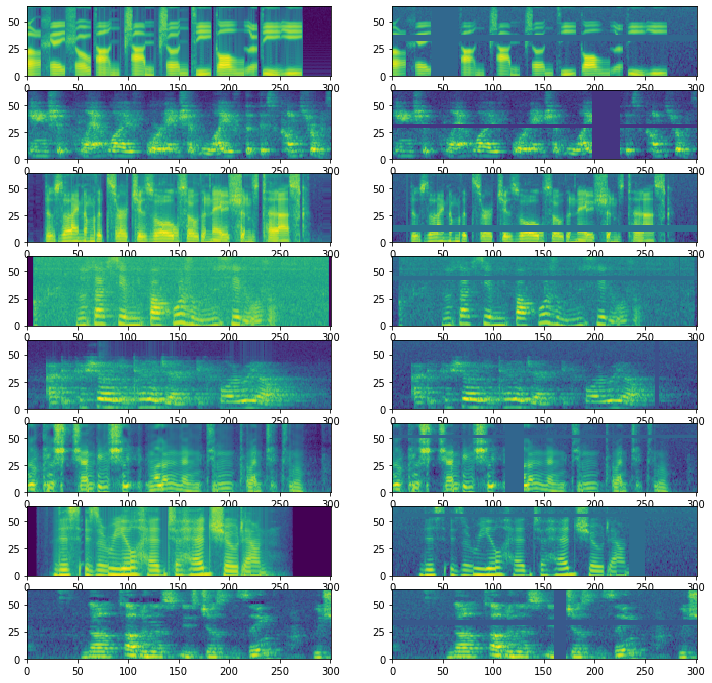

In [20]:
iterator = iter(loader_train)
batch_to_check = next(iterator)[0]

plt.figure(figsize=(12, 12))
for n in range(8):
    wave = batch_to_check[n]
    features_clean = features_extractor.eval()(wave)[0].cpu().numpy()
    features_noisy = features_extractor.train()(wave)[0].cpu().numpy()

    plt.subplot(8, 2, 2 * n + 1)
    plt.pcolormesh(features_clean)
    plt.subplot(8, 2, 2 * n + 2)
    plt.pcolormesh(features_noisy)

## Build Testers

In [21]:
validation = Tester(
    dataset=dataset_valid,
    period=1,
    save_folder=save_folder,
    mode="valid"
    )
evaluation = Tester(
    dataset=dataset_test,
    period=None,
    save_folder=None,
    mode="test"
    )
trainer = Trainer(
    model=model,
    loss=loss,
    autocast=False,
    validation=validation,
    optimizer_fn=optimizer_fn).cuda()


# Train

In [22]:
n_epochs = 5
for n in range(n_epochs):
    trainer.step_epoch(n, dataloader=loader_train)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
evaluating: 100%|██████████| 5000/5000 [01:38<00:00, 50.87it/s]


save model to results/best-auc.torch with best auc score 0.822
save model to results/best-logloss.torch with best logloss 1.834
validation auc score: 0.822
validation logloss: 1.834


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
evaluating: 100%|██████████| 5000/5000 [01:30<00:00, 55.30it/s]


save model to results/best-auc.torch with best auc score 0.981
save model to results/best-logloss.torch with best logloss 0.160
validation auc score: 0.981
validation logloss: 0.160


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
evaluating: 100%|██████████| 5000/5000 [01:30<00:00, 54.98it/s]


validation auc score: 0.966
validation logloss: 0.238


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
evaluating: 100%|██████████| 5000/5000 [01:30<00:00, 55.35it/s]


save model to results/best-auc.torch with best auc score 0.983
save model to results/best-logloss.torch with best logloss 0.139
validation auc score: 0.983
validation logloss: 0.139


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
evaluating: 100%|██████████| 5000/5000 [01:31<00:00, 54.36it/s]


save model to results/best-auc.torch with best auc score 0.988
save model to results/best-logloss.torch with best logloss 0.110
validation auc score: 0.988
validation logloss: 0.110


# Submit

In [23]:
trainer.load_state_dict(torch.load(os.path.join(save_folder, "best-auc.torch")))
scores_test = evaluation(trainer)
filenames = [stem(x.path) for x in sounds_test]
save_file_csv = os.path.join(save_folder, "submission.csv")
pd.DataFrame({"filename": filenames, "score": scores_test}).to_csv(save_file_csv, index=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 10000/10000 [03:08<00:00, 53.18it/s]


# What Next?
1. you can try to use different features (mfcc, fbanks, spectrogramm) with different parameters
2. Use neural network which works with raw singal ([rawnet](https://github.com/Jungjee/RawNet), [sincnet](https://arxiv.org/abs/1808.00158), etc.)
3. Use Image Processing models (efficientnet, resnet, squeezenet, mobilenet, etc.) be carefull by default that model used features dimension == 3, but spectral featrues dim == 1
4. Use Real Noise instead of syntetic, just reimplement "NoiseAugment" to use different real life noises instead of torch.rand. You may use Musan dataset ([link kaggle](https://www.kaggle.com/datasets/nhattruongdev/musan-noise), [link openslr](https://www.openslr.org/17/)) for this
5. Add pitch for specaug
6. Use K-fold technique
7. Voice Activiti Detection make a sense
8. Fusion or stacking

GL;HF